# Project: Wrangle and Analyze Data
### By Abd-elrhman Mohey

### The Data

### Enhanced Twitter Archive

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).
Extracted data from tweet text

<img src = "https://video.udacity-data.com/topher/2017/October/59dd4791_screenshot-2017-10-10-18.19.36/screenshot-2017-10-10-18.19.36.png" height = 400px, width= 800px>

<center><em><strong>The extracted data from each tweet's text</strong></em></center>

I extracted this data programmatically, but I didn't do a very good job. The ratings probably aren't all correct. Same goes for the dog names and probably dog stages (see below for more information on these) too. You'll need to assess and clean these columns if you want to use them for analysis and visualization.

<img src="https://video.udacity-data.com/topher/2017/October/59e04ceb_dogtionary-combined/dogtionary-combined.png" height = 400px, width=900px>

<center><em><strong>The Dogtionary explains the various stages of dog: doggo, pupper, puppo, and floof(er) (via the <a href = "https://www.amazon.com/WeRateDogs-Most-Hilarious-Adorable-Youve/dp/1510717145">#WeRateDogs</a> book on Amazon)</strong></em></center>

### Additional Data via the Twitter API

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But you, because you have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. And guess what? You're going to query Twitter's API to gather this valuable data.

### Image Predictions File

One more cool thing: I ran every image in the WeRateDogs Twitter archive through a [neural network](https://www.youtube.com/watch?v=2-Ol7ZB0MmU) that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

<img src="https://video.udacity-data.com/topher/2017/October/59dd4d2c_screenshot-2017-10-10-18.43.41/screenshot-2017-10-10-18.43.41.png" width = 900px, height=400px>
<center><em><strong>Tweet image prediction data</strong></em></center>

So for the last row in that table:

* tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
* p1 is the algorithm's #1 prediction for the image in the tweet → <strong>golden retriever</strong>
* p1_conf is how confident the algorithm is in its #1 prediction → <strong>95%</strong>
* p1_dog is whether or not the #1 prediction is a breed of dog → <strong>TRUE</strong>
* p2 is the algorithm's second most likely prediction → Labrador <strong>retriever</strong>
* p2_conf is how confident the algorithm is in its #2 prediction → <strong>1%</strong>
* p2_dog is whether or not the #2 prediction is a breed of dog → <strong>TRUE</strong>
* etc.

And the #1 prediction for the image in that tweet was spot on:

<img src="https://video.udacity-data.com/topher/2017/October/59dd4e05_dog-pred/dog-pred.png" width = 250px, height=200px>
<center><strong>A golden retriever named Stuart</strong></center>

So that's all fun and good. But all of this additional data will need to be gathered, assessed, and cleaned. This is where you come in.

### Project Details

my tasks in this project are:
1. Gathering data
2. Assessing data
3. Cleaning data


In [1]:
#import needed libs 
import pandas as pd
import numpy as np 
import tweepy
import requests
import json
import os
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
pd.set_option('display.max_columns', None)

### Gathering Data for this Project


1.  The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: [`twitter_archive_enhanced.csv`](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)

In [2]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'
response = requests.get(url)
with open(os.path.join(os.getcwd(), url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)
    
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
779,775842724423557120,NaN,NaN,2016-09-13 23:44:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Blue. He was having an average day unt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/775842724...,12,10,Blue,None,None,None,None
907,757741869644341248,NaN,NaN,2016-07-26 00:58:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leonard. He hides in bushes to escape ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/757741869...,10,10,Leonard,None,None,None,None
2170,669351434509529089,NaN,NaN,2015-11-25 03:06:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sully. He's a Leviticus Galapagos. Ver...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669351434...,10,10,Sully,None,None,None,None



2.  The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (`image_predictions.tsv`) is hosted on Udacity's servers and should be downloaded programmatically using the [Requests](https://pypi.org/project/requests/) library and the following URL: [https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)

In [3]:
# Download the image prediction file .
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)
with open(os.path.join(os.getcwd(), url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)
    
image_pred = pd.read_csv('image-predictions.tsv', sep = '\t')
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True



3.  Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's [Tweepy](http://www.tweepy.org/) library and store each tweet's entire set of JSON data in a file called `tweet_json.txt` file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. _Note: do not include your Twitter API keys, secrets, and tokens in your project submission._


### note 
the twitter developer not opening for me 

tweet_json.txt: This is the resulting data from twitter_api.py. You can proceed with the following part of "Gathering Data for this Project" on the Project Details page: "Then read this tweet_json.txt file line by line into a pandas DataFrame with (at minimum) **tweet ID** , **retweet count**, and **favorite count**."

In [4]:
tweet_id = []
favorite_count = []
retweet_count = []
with open('tweet-json.txt', encoding='utf-8') as json_file:  
    for line in json_file.readlines():
            tweet_data = json.loads(line)
            tweet_id.append(tweet_data['id'])
            favorite_count.append(tweet_data['favorite_count'])
            retweet_count.append(tweet_data['retweet_count'])
            
json_data = pd.DataFrame({'tweet_id':tweet_id, 'favorite_count':favorite_count, 'retweet_count':retweet_count})
json_data.sample(5)

,tweet_id,favorite_count,retweet_count
350,831322785565769729,10042,1744
489,813812741911748608,40402,16267
2269,667495797102141441,565,294
2217,668496999348633600,436,146
1812,676617503762681856,3149,1108


### Assessing Data for this Project

After gathering each of the above pieces of data,we assess them visually and programmatically for quality and tidiness issues.


### starting with source No.01 The WeRateDogs Twitter archive. 

In [5]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [6]:
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1379,701545186879471618,NaN,NaN,2016-02-21 23:13:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Millie. She's practicing her dive form fo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/701545186...,10,10,Millie,None,None,pupper,None
1792,677334615166730240,NaN,NaN,2015-12-17 03:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog gave up mid jump. 9/10 https://t.co/K...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677334615...,9,10,None,None,None,None,None
581,800443802682937345,NaN,NaN,2016-11-20 21:00:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sampson. He's about to ...,7.761133e+17,4.196984e+09,2016-09-14 17:40:06 +0000,https://twitter.com/dog_rates/status/776113305...,11,10,Sampson,None,None,pupper,None
2050,671497587707535361,NaN,NaN,2015-12-01 01:14:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pip. He is a ship captain. Many years ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671497587...,11,10,Pip,None,None,None,None
392,826115272272650244,NaN,NaN,2017-01-30 17:10:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ike. He's demonstrating the pupmost re...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826115272...,13,10,Ike,None,None,None,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
413,822872901745569793,NaN,NaN,2017-01-21 18:26:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/822872901...,13,10,None,None,None,None,puppo
1319,706516534877929472,NaN,NaN,2016-03-06 16:27:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please enjoy this pup in a cooler. Permanently...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706516534...,12,10,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
2329,666373753744588802,NaN,NaN,2015-11-16 21:54:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Those are sunglasses and a jean jacket. 11/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666373753...,11,10,None,None,None,None,None


In [7]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [8]:
twitter_archive[twitter_archive.tweet_id.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [9]:
twitter_archive[twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [10]:
twitter_archive.name.value_counts()[:10]

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
Lucy        11
Lola        10
Penny       10
Tucker      10
Bo           9
Name: name, dtype: int64

In [11]:
twitter_archive.rating_numerator.value_counts()[:10]

12    558
11    464
10    461
13    351
9     158
8     102
7      55
14     54
5      37
6      32
Name: rating_numerator, dtype: int64

In [12]:
twitter_archive.rating_denominator.value_counts()[:10]

10    2333
11       3
50       3
80       2
20       2
2        1
16       1
40       1
70       1
15       1
Name: rating_denominator, dtype: int64

#### source No.02 The tweet image predictions.

In [13]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
image_pred.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1744,822872901745569793,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True
1928,858107933456039936,https://pbs.twimg.com/media/C-icm_WXUAAmuRR.jpg,1,golden_retriever,0.863874,True,Labrador_retriever,0.015920,True,doormat,0.010615,False
1393,767191397493538821,https://pbs.twimg.com/media/CqWcgcqWcAI43jm.jpg,1,patio,0.708665,False,boathouse,0.110056,False,pier,0.039532,False
274,670833812859932673,https://pbs.twimg.com/media/CU9HyzSWIAAVcte.jpg,1,Pekinese,0.609853,True,Persian_cat,0.265442,False,Japanese_spaniel,0.027460,True
645,681610798867845120,https://pbs.twimg.com/media/CXWRZBgWkAEHMea.jpg,1,toy_poodle,0.821704,True,miniature_poodle,0.116042,True,Yorkshire_terrier,0.014847,True
1101,720785406564900865,https://pbs.twimg.com/media/CgC-gMCWcAAawUE.jpg,1,Chihuahua,0.896422,True,dingo,0.027929,False,kelpie,0.017916,True
555,677662372920729601,https://pbs.twimg.com/media/CWeKTZTWsAA5R3Z.jpg,1,cowboy_hat,0.256110,False,trench_coat,0.127086,False,cloak,0.071439,False
1781,828708714936930305,https://pbs.twimg.com/media/C4AqLSgVYAEg8nt.jpg,1,hippopotamus,0.942911,False,Mexican_hairless,0.008388,True,ice_lolly,0.006206,False
1278,750101899009982464,https://pbs.twimg.com/media/Cmjlsh1XgAEvhq_.jpg,2,golden_retriever,0.316704,True,llama,0.174269,False,Labrador_retriever,0.147364,True
213,670040295598354432,https://pbs.twimg.com/media/CUx2F6lVEAAvFev.jpg,1,web_site,0.901552,False,borzoi,0.026660,True,Chihuahua,0.012438,True


In [15]:
image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### source No.03 additional information 

In [16]:
json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [17]:
json_data.sample(10)

,tweet_id,favorite_count,retweet_count
449,818646164899774465,0,24069
71,878604707211726852,30931,7582
827,768909767477751808,0,3129
1889,674764817387900928,852,263
1130,728760639972315136,5090,1911
2320,666430724426358785,330,204
549,804738756058218496,15326,4480
2034,671729906628341761,9119,4795
454,818307523543449600,0,9366
1772,678023323247357953,2095,439


In [18]:
json_data.describe()

,tweet_id,favorite_count,retweet_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


#### Data Tidiness Issues

- The 3 sources of the data should be in one dataframe. so i need to merge them together 
- Dog types should be in one column 
- Separate timestamp into day - month - year (3 columns)

- ctreate full dog rating


#### Data Quality Issues

- alot of missing values in some column
- change datestamp into datetime 
- Change tweet_id from an integer to a string
- missing data for the dog breed predictions
- Many dog breed names are in lowercase in the p1, the p2 and the p3 columns. 
- Capitalize all words found in columns 'p1', 'p2' and 'p3'.
- Some names in the name columns can't possibly be dog names. (a, the, an, this...)
- we dont need the retweet only original tweets counts 
- there is some tweets with no images 
- scrapping the text errors (manual fix) some dog rating is wrong scrapped form original tweets
- see and drop uneeded columns


### Cleaning Data for this Project

##### Define
Merge the json_data dataframe, the twitter dataframe, and the pred dataframe in new DF to save an old copy

##### Code

In [19]:
#creat copp to new DF
df = twitter_archive.copy()
#Merging tweet_archive & additionl data from api.
df = pd.merge(df, json_data, on = 'tweet_id', how = 'inner')

In [20]:
#Merging The dataframe with the image prediction data 
df = pd.merge(df, image_pred, on ='tweet_id', how = 'inner')

##### Test

In [21]:
df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1955,668142349051129856,NaN,NaN,2015-11-21 19:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This lil pup is Oliver. Hops around. Has wings...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668142349...,2,10,None,None,None,None,None,592,306,https://pbs.twimg.com/media/CUW37BzWsAAlJlN.jpg,1,Angora,0.918834,False,hen,0.037793,False,wood_rabbit,0.011015,False
61,879050749262655488,NaN,NaN,2017-06-25 18:56:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Steven. He has trouble relating to oth...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879050749...,11,10,Steven,None,None,None,None,23022,4941,https://pbs.twimg.com/media/DDMD_phXoAQ1qf0.jpg,1,tabby,0.311861,False,window_screen,0.169123,False,Egyptian_cat,0.132932,False
1907,668979806671884288,NaN,NaN,2015-11-24 02:29:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chaz. He's an X Games half pipe supers...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668979806...,12,10,Chaz,None,None,None,None,842,382,https://pbs.twimg.com/media/CUixld6WoAArDrJ.jpg,1,golden_retriever,0.608537,True,Irish_setter,0.097078,True,redbone,0.076022,True
553,787810552592695296,NaN,NaN,2016-10-17 00:20:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Frank. He wears sunglasses and walks h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/787810552...,11,10,Frank,None,None,None,None,9717,3540,https://pbs.twimg.com/media/Cu7dg2RXYAIaGXE.jpg,2,pug,0.362835,True,French_bulldog,0.221864,True,English_setter,0.080418,True
1543,676811746707918848,NaN,NaN,2015-12-15 17:11:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Penny &amp; Gizmo. They are pract...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676811746...,9,10,Penny,None,None,None,None,1536,469,https://pbs.twimg.com/media/CWSEsO9WwAAX-fZ.jpg,1,Chihuahua,0.440916,True,Pomeranian,0.345806,True,cocker_spaniel,0.060331,True
683,766423258543644672,NaN,NaN,2016-08-18 23:55:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shadoe. Her tongue flies out of her mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/766423258...,9,10,Shadoe,None,None,None,None,6671,1825,https://pbs.twimg.com/media/CqLh4yJWcAAHomv.jpg,2,keeshond,0.995823,True,Pomeranian,0.003897,True,Norwegian_elkhound,0.000253,True
2011,667152164079423490,NaN,NaN,2015-11-19 01:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pipsy. He is a fluffball. Enjoys trave...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None,49720,18285,https://pbs.twimg.com/media/CUIzWk_UwAAfUNq.jpg,1,toy_poodle,0.535411,True,Pomeranian,0.087544,True,miniature_poodle,0.062050,True
739,757729163776290825,NaN,NaN,2016-07-26 00:08:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Chompsky. He lives up t...,6.790626e+17,4.196984e+09,2015-12-21 22:15:18 +0000,https://twitter.com/dog_rates/status/679062614...,11,10,Chompsky,None,None,None,None,0,9299,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1400,683142553609318400,NaN,NaN,2016-01-02 04:27:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Brandy. She's a member of the Bloods. Men...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683142553...,9,10,Brandy,None,None,pupper,None,3162,1173,https://pbs.twimg.com/media/CXsChyjW8AQJ16C.jpg,1,Leonberg,0.605851,True,chow,0.183470,True,German_shepherd,0.079662,True
1759,671561002136281088,NaN,NaN,2015-12-01 05:26:34 +0000,"<a href=""http://twitter.com/download/iph

##### define
clean the 4 types of dogs column into one column <br>
gonna do that by extract the string from the 4 columns and add them into single column wiche will take none if all none or value if the record has value 

##### code 

In [22]:
df['dog_type'] = df['text'].str.extract('(doggo|floofer|pupper|puppo)')

##### test

In [23]:
df.dog_type.value_counts()

pupper     230
doggo       75
puppo       29
floofer      3
Name: dog_type, dtype: int64

##### define
change datestamp into datetime

##### code 

In [24]:
df['timestamp'] = pd.DatetimeIndex(df['timestamp']) 

##### test 

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 31 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null datetime64[ns]
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
favorite_count             

##### define 
covert time stamp column into 3 separate columns with year , month and day.

##### code


In [26]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day

##### test

In [27]:
df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,year,month,day
1709,672877615439593473,NaN,NaN,2015-12-04 20:38:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Oscar. He's getting bombarded with the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672877615...,8,10,Oscar,None,None,None,None,1096,405,https://pbs.twimg.com/media/CVaKn75XAAEU09u.jpg,1,Chihuahua,0.412362,True,beagle,0.068066,True,borzoi,0.045071,True,NaN,2015,12,4
1775,671390180817915904,NaN,NaN,2015-11-30 18:07:47,"<a href=""http://twitter.com/download/iphone"" r...",Striped dog here. Having fun playing on back. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671390180...,7,10,None,None,None,None,None,1513,805,https://pbs.twimg.com/media/CVFBzpXVEAAHIOv.jpg,1,zebra,0.997673,False,tiger,0.000837,False,prairie_chicken,0.000575,False,NaN,2015,11,30
1450,680497766108381184,NaN,NaN,2015-12-25 21:18:05,"<a href=""http://twitter.com/download/iphone"" r...",Meet Percy. He's a Latvian Yuletide Heineken. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680497766...,12,10,Percy,None,None,None,None,4639,2162,https://pbs.twimg.com/media/CXGdG0aWcAEbOO1.jpg,1,Chihuahua,0.538354,True,muzzle,0.084289,False,ski_mask,0.076690,False,NaN,2015,12,25
1379,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,130,None,None,None,None,None,1369,239,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,2,golden_retriever,0.203249,True,Samoyed,0.067958,True,Great_Pyrenees,0.065327,True,pupper,2016,1,5
1961,667902449697558528,NaN,NaN,2015-11-21 03:08:47,"<a href=""http://twitter.com/download/iphone"" r...",This is Cleopatricia. She is a northern Paperb...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667902449...,9,10,Cleopatricia,None,None,None,None,905,396,https://pbs.twimg.com/media/CUTdvAJXIAAMS4q.jpg,1,Norwegian_elkhound,0.298881,True,malamute,0.279479,True,Eskimo_dog,0.198428,True,NaN,2015,11,21
1215,696877980375769088,NaN,NaN,2016-02-09 02:07:12,"<a href=""http://twitter.com/download/iphone"" r...",This is Misty. She's in a predicament. Not sur...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/696877980...,9,10,Misty,None,None,pupper,None,2689,802,https://pbs.twimg.com/media/CavO0uuWEAE96Ed.jpg,1,space_heater,0.206876,False,spatula,0.123450,False,vacuum,0.119218,False,pupper,2016,2,9
231,838476387338051585,NaN,NaN,2017-03-05 19:48:43,"<a href=""http://twitter.com/download/iphone"" r...",This is Stanley. Somehow he heard you tell him...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/838476387...,13,10,Stanley,None,None,None,None,24664,5484,https://pbs.twimg.com/media/C6Ld0wYWgAQQqMC.jpg,3,Great_Pyrenees,0.997692,True,kuvasz,0.001001,True,Newfoundland,0.000405,True,NaN,2017,3,5
945,727644517743104000,NaN,NaN,2016-05-03 23:42:26,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo struggling to cope with the win...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/727644517...,13,10,None,doggo,None,None,None,6431,1962,https://pbs.twimg.com/media/Chkc1BQUoAAa96R.jpg,2,Great_Pyrenees,0.457164,True,kuvasz,0.391710,True,Labrador_retriever,0.094523,True,doggo,2016,5,3
441,805826884734976000,NaN,NaN,2016-12-05 17:31:15,"<a href=""http://twitter.com/download/iphone"" r...",This is Duke. He is not a fan of the pupporazz...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/805826884...,12,10,Duke,None,None,None,None,7335,2132,https://pbs.twimg.com/ext_tw_video_thumb/80582...,1,Siberian_husky,0.248926,True,American_Staffordshire_terrier,0.098313,True,Eskimo_dog,0.080188,True,puppo,2016,12,5


##### define
clean the columns with alot of missing values <br>
drop any column with more than 70 % missing values 

##### code 

In [28]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})


In [29]:
missing_column = []
for i in missing_value_df[missing_value_df['percent_missing'] > 70].iterrows():
    missing_column.append(i[0])
df.drop(columns = missing_column,inplace = True)
missing_column

['in_reply_to_status_id',
 'in_reply_to_user_id',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'dog_type']

##### test

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id              2073 non-null int64
timestamp             2073 non-null datetime64[ns]
source                2073 non-null object
text                  2073 non-null object
expanded_urls         2073 non-null object
rating_numerator      2073 non-null int64
rating_denominator    2073 non-null int64
name                  2073 non-null object
doggo                 2073 non-null object
floofer               2073 non-null object
pupper                2073 non-null object
puppo                 2073 non-null object
favorite_count        2073 non-null int64
retweet_count         2073 non-null int64
jpg_url               2073 non-null object
img_num               2073 non-null int64
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null bool
p2                    2073 non-null object
p2_conf               2073 non-n

##### define 
Change tweet_id from an integer to a string


##### code

In [31]:
df['tweet_id'] = df['tweet_id'].astype(str)
df['img_num'] = df['img_num'].astype(str)

##### test

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id              2073 non-null object
timestamp             2073 non-null datetime64[ns]
source                2073 non-null object
text                  2073 non-null object
expanded_urls         2073 non-null object
rating_numerator      2073 non-null int64
rating_denominator    2073 non-null int64
name                  2073 non-null object
doggo                 2073 non-null object
floofer               2073 non-null object
pupper                2073 non-null object
puppo                 2073 non-null object
favorite_count        2073 non-null int64
retweet_count         2073 non-null int64
jpg_url               2073 non-null object
img_num               2073 non-null object
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null bool
p2                    2073 non-null object
p2_conf               2073 non

##### define 
missing data for the dog breed predictions <br>
Drop rows that do not have a jpg_url column as tweets without a jpg_url do not contain images.

In [33]:
df=df[~df.jpg_url.isnull()]

##### test

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id              2073 non-null object
timestamp             2073 non-null datetime64[ns]
source                2073 non-null object
text                  2073 non-null object
expanded_urls         2073 non-null object
rating_numerator      2073 non-null int64
rating_denominator    2073 non-null int64
name                  2073 non-null object
doggo                 2073 non-null object
floofer               2073 non-null object
pupper                2073 non-null object
puppo                 2073 non-null object
favorite_count        2073 non-null int64
retweet_count         2073 non-null int64
jpg_url               2073 non-null object
img_num               2073 non-null object
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null bool
p2                    2073 non-null object
p2_conf               2073 non

#### Define
Capitalize all words found in columns 'p1', 'p2' and 'p3'.

#### Code

In [35]:
df['p1'] = df['p2'].str.title()
df['p2'] = df['p2'].str.title()
df['p3'] = df['p3'].str.title()

#### Test

In [36]:
df.loc[:,['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
1200,Cardigan,Cardigan,Shetland_Sheepdog
1958,Hog,Hog,Newfoundland
1163,Staffordshire_Bullterrier,Staffordshire_Bullterrier,Chihuahua
373,French_Bulldog,French_Bulldog,German_Shepherd
643,Shih-Tzu,Shih-Tzu,Welsh_Springer_Spaniel
993,English_Springer,English_Springer,Bath_Towel
1632,Malinois,Malinois,Bull_Mastiff
1063,Pomeranian,Pomeranian,Golden_Retriever
412,Labrador_Retriever,Labrador_Retriever,Golden_Retriever
1270,Collie,Collie,Border_Collie


##### define 
we dont need the retweet only original tweets counts

##### code 
allready solved and droped the column with missing values 

##### define 
there is some tweets with no images 

##### code 
allready solved and droped the column when was cleaing missing data for predictions 

##### define 
see and drop uneeded columns 

##### code


In [37]:
df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'favorite_count', 'retweet_count', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'year', 'month', 'day'],
      dtype='object')

In [38]:
df = df.drop(['source',            
              'expanded_urls'], 1)

##### test

In [39]:
df.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'favorite_count', 'retweet_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'year', 'month', 'day'],
      dtype='object')

##### re assess the rating_numerator , rating_denominator

In [40]:

df[df.rating_denominator != 10][['text' , 'rating_numerator',  'rating_denominator']].style.set_properties(subset=['text'], **{'width': '500px'})

,text,rating_numerator,rating_denominator
345,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
415,Meet Sam. She smiles 24/7 & secretly aspires to be a reindeer. Keep Sam smiling by clicking and sharing this link: https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
734,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
876,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
924,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
967,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1001,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1022,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1047,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1065,"From left to right: Cletus, Jerome, Alejandro, Burp, & Titson None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


##### define 
some of the tweets were scrapped with wrong rating <br> i have to edit them manually 


##### code 

In [41]:
'''876   After so many requests, this is Bretagne. 
She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ'''
df.loc[876 ,'rating_numerator']  = 14
df.loc[876 ,'rating_denominator']  = 10
'''
967	Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a	4	20
'''
df.loc[ 967,'rating_numerator']  = 13
df.loc[ 967,'rating_denominator']  = 10
'''
1001	This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
'''
df.loc[ 1001,'rating_numerator']  = 11
df.loc[ 1001,'rating_denominator']  = 10
'''
1405  This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5	
'''
df.loc[1405 ,'rating_numerator']  = 10
df.loc[1405 ,'rating_denominator']  = 10
'''
2052	This is an Albanian 3 1/2 legged Episcopalian. 
Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv	1	2
'''
df.loc[2052 ,'rating_numerator']  = 9
df.loc[2052 ,'rating_denominator']  =10 

##### test

In [42]:

df[df.rating_denominator != 10][['text' , 'rating_numerator',  'rating_denominator']].style.set_properties(subset=['text'], **{'width': '500px'})

,text,rating_numerator,rating_denominator
345,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
415,Meet Sam. She smiles 24/7 & secretly aspires to be a reindeer. Keep Sam smiling by clicking and sharing this link: https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
734,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
924,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1022,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1047,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1065,"From left to right: Cletus, Jerome, Alejandro, Burp, & Titson None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
1131,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50
1207,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
1379,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130


In [43]:
df[df['text'].str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator', 'rating_denominator']].style.set_properties(subset=['text'], **{'width': '500px'})


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator,rating_denominator
40,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
558,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
614,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1451,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


##### code 

In [44]:
'''40	This is Bella. She hopes her smile made you smile. If not, 
she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948	'''
df.loc[40 ,'rating_numerator']  = 13.5
df.loc[40 ,'rating_denominator']  = 10
'''
558	This is Logan, the Chow who lived. 
He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
'''
df.loc[ 558,'rating_numerator']  = 9.75
df.loc[ 558,'rating_denominator']  = 10
'''
614	This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. 
Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq	
'''
df.loc[ 614,'rating_numerator']  = 11.27
df.loc[ 614,'rating_denominator']  = 10
'''
1451	Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD	26	10
'''
df.loc[1405 ,'rating_numerator']  = 11.26
df.loc[1405 ,'rating_denominator']  = 10

##### test

In [45]:
df[df['text'].str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator', 'rating_denominator']].style.set_properties(subset=['text'], **{'width': '500px'})


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator,rating_denominator
40,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10
558,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10
614,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10
1451,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


##### define 
convert the rating type into float 


##### code 

In [46]:
df[['rating_numerator', 'rating_denominator']] = df[['rating_numerator','rating_denominator']].astype(float)

#### test 

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 26 columns):
tweet_id              2073 non-null object
timestamp             2073 non-null datetime64[ns]
text                  2073 non-null object
rating_numerator      2073 non-null float64
rating_denominator    2073 non-null float64
name                  2073 non-null object
doggo                 2073 non-null object
floofer               2073 non-null object
pupper                2073 non-null object
puppo                 2073 non-null object
favorite_count        2073 non-null int64
retweet_count         2073 non-null int64
jpg_url               2073 non-null object
img_num               2073 non-null object
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null bool
p2                    2073 non-null object
p2_conf               2073 non-null float64
p2_dog                2073 non-null bool
p3                    2073 

##### define 
ctreate full dog rating <br>
rating_numerator /rating_denominator

##### code

In [48]:
df['dog_rating'] = df['rating_numerator'] / df['rating_denominator']

##### test

In [49]:
df.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,year,month,day,dog_rating
760,754482103782404096,2016-07-17 01:05:25,This is Milo. He's currently plotting his reve...,10.0,10.0,Milo,None,None,None,None,5852,2220,https://pbs.twimg.com/ext_tw_video_thumb/75448...,1,Bathtub,0.596796,False,Bathtub,0.381098,False,Shower_Curtain,0.017629,False,2016,7,17,1.0
973,720415127506415616,2016-04-14 00:55:25,Garden's coming in nice this year. 10/10 https...,10.0,10.0,None,None,None,None,None,4503,1681,https://pbs.twimg.com/media/Cf9tuHUWsAAHSrV.jpg,1,Black-And-Tan_Coonhound,0.990312,True,Black-And-Tan_Coonhound,0.002495,True,American_Black_Bear,0.001733,False,2016,4,14,1.0
248,835172783151792128,2017-02-24 17:01:22,We only rate dogs. Please don't send in any no...,12.0,10.0,None,None,None,None,None,28552,6516,https://pbs.twimg.com/media/C5chM_jWAAQmov9.jpg,2,Collie,0.663138,True,Collie,0.152494,True,Cardigan,0.035471,True,2017,2,24,1.2
918,732732193018155009,2016-05-18 00:39:02,This is Ralpher. He's an East Guinean Flop Dog...,12.0,10.0,Ralpher,None,None,None,None,2671,599,https://pbs.twimg.com/media/CiswCQhWYAI5-QW.jpg,1,Staffordshire_Bullterrier,0.162935,False,Staffordshire_Bullterrier,0.127969,True,Mongoose,0.096421,False,2016,5,18,1.2
379,816091915477250048,2017-01-03 01:20:49,This is Comet. He's a Wild Estonian Poofer. Su...,12.0,10.0,Comet,None,None,None,None,9927,2500,https://pbs.twimg.com/media/C1NXQ6NXUAEAxIQ.jpg,3,Samoyed,0.967345,True,Samoyed,0.007397,True,Papillon,0.006017,True,2017,1,3,1.2


##### define 
some dog rating_numerator is very high <br>
manually find and edit

In [50]:
df[df['dog_rating'] >2][['text' , 'rating_numerator',  'rating_denominator' , 'dog_rating']].style.set_properties(subset=['text'], **{'width': '500px'})
#first one no ratiing so it must be deleted 
# second one not fair rating 
# third one is cool to stay
# fourth one is snoop dog so delete 

,text,rating_numerator,rating_denominator,dog_rating
415,Meet Sam. She smiles 24/7 & secretly aspires to be a reindeer. Keep Sam smiling by clicking and sharing this link: https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7,3.42857
802,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10,177.6
1451,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10,2.6
1795,After so many requests... here you go. Good dogg. 420/10 https://t.co/yfAAo1gdeY,420,10,42


#### code 


In [51]:
df.drop([415, 802 , 1795], inplace = True)

##### test

In [52]:
df[df['dog_rating'] >2][['text' , 'rating_numerator',  'rating_denominator' , 'dog_rating']].style.set_properties(subset=['text'], **{'width': '500px'})


,text,rating_numerator,rating_denominator,dog_rating
1451,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10,2.6


##### define 
drop name for each dog named a

##### code 

In [53]:
df['name'].value_counts()[:10]

None       576
a           55
Charlie     11
Oliver      10
Cooper      10
Penny       10
Lucy        10
Tucker      10
Lola         8
Sadie        8
Name: name, dtype: int64

In [54]:
df[df['name'] == "a"][['text' ,'name']].style.set_properties(subset=['text'], **{'width': '500px'})
df.loc[df.name == "a"] = None
df.loc[df.name == "None"] = None

##### test

In [55]:
df[df['name'] == "a"][['text' ,'name']].style.set_properties(subset=['text'], **{'width': '500px'})

,text,name


<a id='storing'></a>
## Storing, Analyzing, and Visualizing Data

In [56]:
#Store the clean DataFrame in a CSV file
df.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

In [57]:
df[df['dog_rating'] == 177.6]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,year,month,day,dog_rating


In [58]:
df.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,year,month,day,dog_rating
count,1439.000000,1439.000000,1439.000000,1439.00000,1439.000000,1439.000000,1.439000e+03,1439.000000,1.439000e+03,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000
mean,10.871981,10.111188,9115.807505,2996.62057,0.598758,0.769979,1.346720e-01,0.783183,6.081719e-02,0.753301,2015.938846,6.970118,15.719944,1.073855
std,5.445160,4.217835,11689.235627,4468.60382,0.272932,0.420992,1.007537e-01,0.412220,5.164388e-02,0.431240,0.694013,4.064819,9.038634,0.192227
min,2.000000,10.000000,0.000000,23.00000,0.044333,0.000000,1.011300e-08,0.000000,1.740170e-10,0.000000,2015.000000,1.000000,1.000000,0.200000
25%,10.000000,10.000000,2118.000000,735.00000,0.368254,1.000000,5.270490e-02,1.000000,1.587200e-02,1.000000,2015.000000,3.000000,8.000000,1.000000
50%,11.000000,10.000000,4578.000000,1645.00000,0.594333,1.000000,1.201840e-01,1.000000,4.947150e-02,1.000000,2016.000000,7.000000,16.000000,1.100000
75%,12.000000,10.000000,11913.000000,3639.00000,0.860575,1.000000,1.978790e-01,1.000000,9.439135e-02,1.000000,2016.000000,11.000000,24.000000,1.200000
max,204.000000,170.000000,107956.000000,56625.00000,1.000000,1.000000,4.880140e-01,1.000000,2.734190e-01,1.000000,2017.000000,12.000000,31.000000,1.400000


- The **mean dog rating** for the dataset is 1.06.
- The **most dog rating** for the dataset is 2.6. it was for some cute dogs in one pic

- The **mean FAVORITE count** for dogs is 8559.7
- The **most FAVORITE tweet** for dogs is 132810

- the **mean Retweet** on the other hand was 2976.17
- The **most retweeted** tweet was retweeted 79515. times.

In [59]:
df['name'].value_counts()[:10]

Charlie    11
Cooper     10
Oliver     10
Penny      10
Tucker     10
Lucy       10
Lola        8
Bo          8
Winston     8
Sadie       8
Name: name, dtype: int64

Text(0.5,1,'Most names for Dogs')

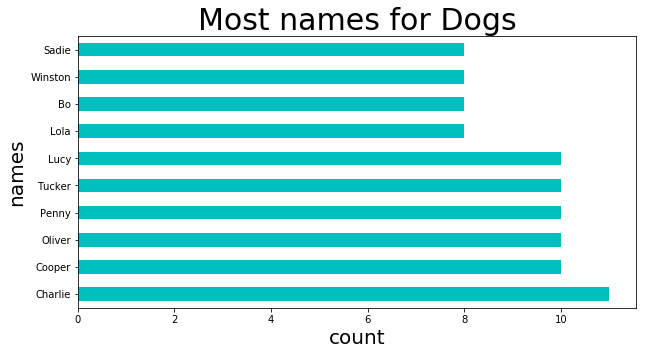

In [60]:
plt.figure(figsize=(10, 5))
df['name'].value_counts()[:10].plot(kind='barh' , color='c');
plt.xlabel("count", size= 20);
plt.ylabel("names" , size = 20);
plt.title("Most names for Dogs" , size = 30)

In [61]:
tweets_per_month = df.groupby(['month', 'year'], 
                               sort=False).count().iloc[::-1, 0]

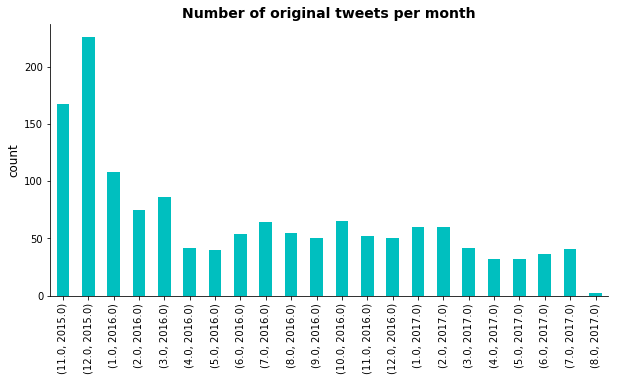

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
tweets_per_month.plot(kind='bar', color='c')
ax.set_title('Number of original tweets per month', fontsize=14, fontweight="bold")
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

we can see that the number of tweets is mostly steady and the same after January 2016

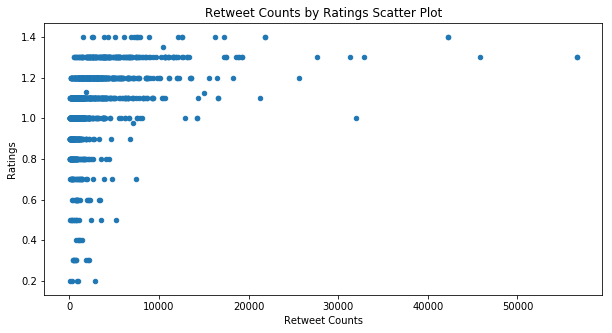

In [63]:
ax = df.plot(x='retweet_count', y='dog_rating', kind='scatter' , figsize=(10, 5));
plt.xlabel('Retweet Counts');
plt.ylabel('Ratings');
plt.title('Retweet Counts by Ratings Scatter Plot');


seems no relationship between rating and the number of retweets 

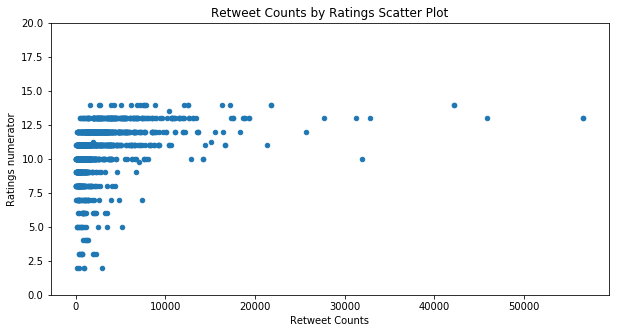

In [64]:
ax = df.plot(x='retweet_count', y='rating_numerator', kind='scatter',figsize=(10, 5));
plt.xlabel('Retweet Counts');
plt.ylabel('Ratings numerator');
plt.title('Retweet Counts by Ratings Scatter Plot');
ax.set_ylim(0,20);


same goes with rating_numerator  no relationship between rating_numerator and the number of retweets